In [2]:
import sys
sys.path.append('../')
from data_read import *
from net import *
import matplotlib.pyplot as plt
import numpy as np

import argparse

import os





parser = argparse.ArgumentParser()


parser.add_argument('--dataset_name', action="store", dest= "dataset_name",default="MSCOCO",help='MSCOCO,GoogleMap,GoogleEarth,DayNight')


parser.add_argument('--epoch_load_one', action="store", dest="epoch_load_one", type=int, default=3,help='epoch_load_one')


parser.add_argument('--epoch_load_two', action="store", dest="epoch_load_two", type=int, default=3,help='epoch_load_two')

parser.add_argument('--epoch_load_three', action="store", dest="epoch_load_three", type=int, default=3,help='epoch_load_three')

parser.add_argument('--num_iters', action="store", dest="num_iters", type=int, default=20,help='num_iters')

parser.add_argument('--feature_map_type', action="store", dest="feature_map_type", default='special',help='regular or special')

parser.add_argument('--initial_type', action="store", dest="initial_type", default='multi_net',help='vanilla, simple_net, multi_net')

parser.add_argument('--load_epoch_simplenet', action="store", dest="load_epoch_simplenet", default=50,help='load_epoch_simplenet')

parser.add_argument('--load_epoch_multinet', action="store", dest="load_epoch_multinet", default=[50,50,40],help='load_epoch_multinet')


input_parameters = parser.parse_args([])




gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4000)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)




def construct_matrix_regression(batch_size,network_output,network_output_2=[0]):
    extra=tf.ones((batch_size,1))
    predicted_matrix=tf.concat([network_output,extra],axis=-1)
    predicted_matrix=tf.reshape(predicted_matrix,[batch_size,3,3])
    if len(np.shape(network_output_2))>1:
        predicted_matrix_2=tf.concat([network_output_2,extra],axis=-1)
        predicted_matrix_2=tf.reshape(predicted_matrix_2,[batch_size,3,3])
    hh_matrix=[]
    for i in range(batch_size):
        if len(np.shape(network_output_2))>1:
            hh_matrix.append(np.linalg.inv(np.dot(predicted_matrix_2[i,:,:],predicted_matrix[i,:,:])))
        else:
            hh_matrix.append(np.linalg.inv(predicted_matrix[i,:,:]))
        #hh_matrix.append(predicted_matrix[i,:,:])
    
    #return tf.linalg.inv(predicted_matrix+0.0001)
    return np.asarray(hh_matrix)

def initial_motion_COCO():
    # prepare source and target four points
    matrix_list=[]
    for i in range(1):
       
        src_points=[[0,0],[127,0],[127,127],[0,127]]

        tgt_points=[[32,32],[160,32],[160,160],[32,160]]

    
        src_points=np.reshape(src_points,[4,1,2])
        tgt_points=np.reshape(tgt_points,[4,1,2])

        # find homography
        h_matrix, status = cv2.findHomography(src_points, tgt_points,0)
        matrix_list.append(h_matrix)
    return np.asarray(matrix_list).astype(np.float32)


def construct_matrix(initial_matrix,scale_factor,batch_size):
    #scale_factor size_now/(size to get matrix)
    initial_matrix=tf.cast(initial_matrix,dtype=tf.float32)
    
    scale_matrix=np.eye(3)*scale_factor
    scale_matrix[2,2]=1.0
    scale_matrix=tf.cast(scale_matrix,dtype=tf.float32)
    scale_matrix_inverse=tf.linalg.inv(scale_matrix)

    scale_matrix=tf.expand_dims(scale_matrix,axis=0)
    scale_matrix=tf.tile(scale_matrix,[batch_size,1,1])

    scale_matrix_inverse=tf.expand_dims(scale_matrix_inverse,axis=0)
    scale_matrix_inverse=tf.tile(scale_matrix_inverse,[batch_size,1,1])

    final_matrix=tf.matmul(tf.matmul(scale_matrix,initial_matrix),scale_matrix_inverse)
    return final_matrix



def average_cornner_error(batch_size,predicted_matrix,u_list,v_list,top_left_u=0,top_left_v=0,bottom_right_u=127,bottom_right_v=127):
    
    four_conner=[[top_left_u,top_left_v,1],[bottom_right_u,top_left_v,1],[bottom_right_u,bottom_right_v,1],[top_left_u,bottom_right_v,1]]
    four_conner=np.asarray(four_conner)
    four_conner=np.transpose(four_conner)
    four_conner=np.expand_dims(four_conner,axis=0)
    four_conner=np.tile(four_conner,[batch_size,1,1]).astype(np.float32)
    
    new_four_points=tf.matmul(predicted_matrix,four_conner)
    
    new_four_points_scale=new_four_points[:,2:,:]
    new_four_points= new_four_points/new_four_points_scale
    
    
    u_predict=new_four_points[:,0,:]
    v_predict=new_four_points[:,1,:]
    
    average_conner=tf.reduce_mean(tf.sqrt(tf.math.pow(u_predict-u_list,2)+tf.math.pow(v_predict-v_list,2)))

    
    
    return average_conner
    





def calculate_feature_map(input_tensor):
    bs,height,width,channel=tf.shape(input_tensor)
    path_extracted=tf.image.extract_patches(input_tensor, sizes=(1,3,3,1), strides=(1,1,1,1), rates=(1,1,1,1), padding='SAME')
    path_extracted=tf.reshape(path_extracted,(bs,height,width,channel,9))
    path_extracted_mean=tf.math.reduce_mean(path_extracted,axis=3,keepdims=True)

    #path_extracted_mean=tf.tile(path_extracted_mean,[1,1,1,channel,1])
    path_extracted=path_extracted-path_extracted_mean
    path_extracted_transpose=tf.transpose(path_extracted,(0,1,2,4,3))
    variance_matrix=tf.matmul(path_extracted_transpose,path_extracted)
    
    tracevalue=tf.linalg.trace(variance_matrix)
    row_sum=tf.reduce_sum(variance_matrix,axis=-1)
    max_row_sum=tf.math.reduce_max(row_sum,axis=-1)
    min_row_sum=tf.math.reduce_min(row_sum,axis=-1)
    mimic_ratio=(max_row_sum+min_row_sum)/2.0/tracevalue
    
    return  tf.expand_dims(mimic_ratio,axis=-1)


if input_parameters.feature_map_type=='regular':
    load_path_one='./checkpoints/'+input_parameters.dataset_name+'/level_one_regular/'

    load_path_two='./checkpoints/'+input_parameters.dataset_name+'/level_two_regular/'

    load_path_three='./checkpoints/'+input_parameters.dataset_name+'/level_three_regular/'

    level_one_input=ResNet_first_input(if_regular=True)
    level_one_template=ResNet_first_template(if_regular=True)
    level_two_input=ResNet_second_input(if_regular=True)
    level_two_template=ResNet_second_template(if_regular=True)
    level_three_input=ResNet_third_input(if_regular=True)
    level_three_template=ResNet_third_template(if_regular=True)

elif input_parameters.feature_map_type=='special':

    load_path_one='./checkpoints/'+input_parameters.dataset_name+'/level_one/'

    load_path_two='./checkpoints/'+input_parameters.dataset_name+'/level_two/'

    load_path_three='./checkpoints/'+input_parameters.dataset_name+'/level_three/'

    level_one_input=ResNet_first_input()
    level_one_template=ResNet_first_template()
    level_two_input=ResNet_second_input()
    level_two_template=ResNet_second_template()
    level_three_input=ResNet_third_input()
    level_three_template=ResNet_third_template()


level_one_input.load_weights(load_path_one + 'epoch_'+str(input_parameters.epoch_load_one)+"input_full")

level_one_template.load_weights(load_path_one + 'epoch_'+str(input_parameters.epoch_load_one)+"template_full")

level_two_input.load_weights(load_path_two + 'epoch_'+str(input_parameters.epoch_load_two)+"input_full")

level_two_template.load_weights(load_path_two  + 'epoch_'+str(input_parameters.epoch_load_two)+"template_full")

level_three_input.load_weights(load_path_three + 'epoch_'+str(input_parameters.epoch_load_three)+"input_full")

level_three_template.load_weights(load_path_three  + 'epoch_'+str(input_parameters.epoch_load_three)+"template_full")


if input_parameters.initial_type=='vanilla':
    initial_matrix=initial_motion_COCO()
    initial_matrix=construct_matrix(initial_matrix,scale_factor=0.25,batch_size=1)

if input_parameters.initial_type=='simple_net':
    save_path_regression='./checkpoints/'+input_parameters.dataset_name+'/regression_stage_1/'
    regression_network=Net_first()
    regression_network.load_weights(save_path_regression + 'epoch_'+str(input_parameters.load_epoch_simplenet))

if input_parameters.initial_type=='multi_net':
    save_path_one='./checkpoints/'+input_parameters.dataset_name+'/regression_stage_1/'
    save_path_two='./checkpoints/'+input_parameters.dataset_name+'/regression_stage_2/'
    save_path_three='./checkpoints/'+input_parameters.dataset_name+'/regression_stage_3/'
    regression_network_one=Net_first()
    regression_network_one.load_weights(save_path_one + 'epoch_'+str(input_parameters.load_epoch_multinet[0]))
    regression_network_two=Net_second()
    regression_network_two.load_weights(save_path_two + 'epoch_'+str(input_parameters.load_epoch_multinet[1]))
    regression_network_three=Net_third()
    regression_network_three.load_weights(save_path_three + 'epoch_'+str(input_parameters.load_epoch_multinet[2]))
    





LK_layer_one=Lucas_Kanade_layer(batch_size=1,height_template=128,width_template=128,num_channels=1)

LK_layer_two=Lucas_Kanade_layer(batch_size=1,height_template=64,width_template=64,num_channels=1)

LK_layer_three=Lucas_Kanade_layer(batch_size=1,height_template=32,width_template=32,num_channels=1)


LK_layer_regression=Lucas_Kanade_layer(batch_size=1,height_template=192,width_template=192,num_channels=3)









if input_parameters.dataset_name=='MSCOCO':
    data_loader_caller=data_loader_MSCOCO('val')

if input_parameters.dataset_name=='GoogleMap':
    data_loader_caller=data_loader_GoogleMap('val')

if input_parameters.dataset_name=='GoogleEarth':
    data_loader_caller=data_loader_GoogleEarth('val')

if input_parameters.dataset_name=='DayNight':
    data_loader_caller=data_loader_DayNight('val')

1 Physical GPUs, 1 Logical GPUs


2025-07-19 00:09:19.508739: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2025-07-19 00:09:19.508755: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-07-19 00:09:19.508758: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2025-07-19 00:09:19.508782: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-07-19 00:09:19.508794: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


6387


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from skimage.transform import resize # Ensure this import is at the top of your notebook/script

# --- YOUR MANUAL IMAGE LOADING AND PREPROCESSING CODE STARTS HERE ---
# 📸 IMPORTANT: Replace 'path/to/your/input_picture.jpg' and 'path/to/your/template_picture.jpg'
# with the actual relative paths to your image files!
input_image_path = 'input2.jpg'
template_image_path = 'temp2.jpg'

# Load and Initially Normalize Images (as done in data_read.py for MSCOCO)
try:
    raw_input_img = plt.imread(input_image_path) / 255.0
    raw_template_img = plt.imread(template_image_path) / 255.0
    print(f"Loaded original input image shape: {raw_input_img.shape}")
    print(f"Loaded original template image shape: {raw_template_img.shape}")

except FileNotFoundError:
    print("Error: One or both of your image files were not found. Please check the paths.")
    # You might want to exit here or handle the error gracefully
    exit()
except Exception as e:
    print(f"An unexpected error occurred while loading images: {e}")
    exit()

# Ensure images have 3 channels (RGB) if they were loaded as grayscale (2D)
if raw_input_img.ndim == 2:
    raw_input_img = np.stack([raw_input_img]*3, axis=-1)
if raw_template_img.ndim == 2:
    raw_template_img = np.stack([raw_template_img]*3, axis=-1)

# Resize Images to Expected Dimensions for the Pipeline
# Input: 192x192, Template: 128x128 (as per model expectations in Visualization.ipynb)
target_input_dim = (192, 192)
target_template_dim = (128, 128)

input_img_resized = resize(raw_input_img, target_input_dim, anti_aliasing=True)
template_img_resized = resize(raw_template_img, target_template_dim, anti_aliasing=True)

print(f"Resized input image for feature extraction shape: {input_img_resized.shape}")
print(f"Resized template image for feature extraction shape: {template_img_resized.shape}")

# Convert NumPy arrays to TensorFlow tensors and add a batch dimension (for a single image).
input_img_tf_batch = tf.expand_dims(tf.convert_to_tensor(input_img_resized, dtype=tf.float32), axis=0)
template_img_tf_batch = tf.expand_dims(tf.convert_to_tensor(template_img_resized, dtype=tf.float32), axis=0)

# Prepare Images for Initial Regression Network
template_img_padded_for_regression = tf.image.pad_to_bounding_box(template_img_tf_batch, 32, 32, 192, 192)

input_img_grey_for_regression = tf.image.rgb_to_grayscale(input_img_tf_batch)
template_img_grey_for_regression = tf.image.rgb_to_grayscale(template_img_padded_for_regression)

# This tensor is the direct input to the initial regression networks.
network_input_for_regression_models = tf.concat([template_img_grey_for_regression, input_img_grey_for_regression], axis=-1)

print(f"Shape of prepared input for regression models: {network_input_for_regression_models.shape}")

# --- Ground Truth Labels for Error Calculation ---
# ⚠️ If you want to calculate 'average_cornner_error', you MUST define the ground truth
#    corner points for your manually added images here.
#    These should be 4 (u,v) pairs for the template in the input image's coordinate system.
#    Example: [[u1,v1],[u2,v2],[u3,v3],[u4,v4]]
#    If you don't have ground truth, the 'average_cornner_error' part will not be accurate or will fail.
#    For now, we'll use placeholder lists so the code can run without error,
#    but these won't result in meaningful error if not replaced with actual data.
u_list_manual = np.array([[0, 127, 127, 0]]) # Placeholder for u-coordinates of 4 corners
v_list_manual = np.array([[0, 0, 127, 127]]) # Placeholder for v-coordinates of 4 corners

# --- END OF YOUR MANUAL IMAGE LOADING AND PREPROCESSING CODE ---

# --- MODIFIED PIPELINE EXECUTION ---
# Modify the outer loop to run only once for your single manual input.
# Also, remove the data_loader_caller.data_read_batch call and the break condition.
total_error = 0.0    
fk_loop = input_parameters.num_iters

# Loop runs only once for manual image processing
for iters in range(1):
    # Map your manually loaded images to the variables used in the original notebook.
    # input_img and template_img here are the RGB images with a batch dimension.
    input_img = input_img_tf_batch
    template_img = template_img_tf_batch
    # Use your manual u_list and v_list for error calculation.
    u_list = u_list_manual
    v_list = v_list_manual
    if input_parameters.initial_type=='simple_net':
        input_img_grey=tf.image.rgb_to_grayscale(input_img)
        template_img_new=tf.image.pad_to_bounding_box(template_img, 32, 32, 192, 192)  
        template_img_grey=tf.image.rgb_to_grayscale(template_img_new)    
        network_input=tf.concat([template_img_grey,input_img_grey],axis=-1)
        homography_vector=regression_network.call(network_input,training=False)
        extra=tf.ones((1,1))
        initial_matrix=tf.concat([homography_vector,extra],axis=-1)
        initial_matrix=tf.reshape(initial_matrix,[1,3,3])
        initial_matrix=construct_matrix(initial_matrix,scale_factor=0.25,batch_size=1)

    if input_parameters.initial_type=='multi_net':
        input_img_grey=tf.image.rgb_to_grayscale(input_img)
        template_img_new=tf.image.pad_to_bounding_box(template_img, 32, 32, 192, 192)  
        template_img_grey=tf.image.rgb_to_grayscale(template_img_new)
        network_input=tf.concat([template_img_grey,input_img_grey],axis=-1)
        homography_vector_one=regression_network_one.call(network_input,training=False)
        matrix_one=construct_matrix_regression(1,homography_vector_one)
        template_img_new=LK_layer_regression.projective_inverse_warp(tf.dtypes.cast(template_img,tf.float32), matrix_one)
        template_img_grey=tf.image.rgb_to_grayscale(template_img_new) 
        network_input=tf.concat([template_img_grey,input_img_grey],axis=-1)
        homography_vector_two=regression_network_two.call(network_input,training=False)
        matrix_two=construct_matrix_regression(1,homography_vector_one,homography_vector_two)
        template_img_new=LK_layer_regression.projective_inverse_warp(tf.dtypes.cast(template_img,tf.float32), matrix_two)
        template_img_grey=tf.image.rgb_to_grayscale(template_img_new)  
        network_input=tf.concat([template_img_grey,input_img_grey],axis=-1)
        homography_vector_three=regression_network_three.call(network_input,training=False)

        extra=tf.ones((1,1))
        initial_matrix=tf.concat([homography_vector_three,extra],axis=-1)
        initial_matrix=tf.reshape(initial_matrix,[1,3,3])
        initial_matrix=np.dot(initial_matrix[0,:,:], np.linalg.inv(matrix_two[0,:,:]))
        initial_matrix=np.expand_dims(initial_matrix,axis=0)
        initial_matrix=construct_matrix(initial_matrix,scale_factor=0.25,batch_size=1)





        
    input_feature_one=level_one_input.call(input_img,training=False)
    template_feature_one=level_one_template.call(template_img,training=False)

    input_feature_two=level_two_input.call(input_feature_one,training=False)
    template_feature_two=level_two_template.call(template_feature_one,training=False)

    input_feature_three=level_three_input.call(input_feature_two,training=False)
    template_feature_three=level_three_template.call(template_feature_two,training=False)


    if input_parameters.feature_map_type=='regular':
        input_feature_map_one=input_feature_one
        template_feature_map_one=template_feature_one

        input_feature_map_two=input_feature_two
        template_feature_map_two=template_feature_two

        input_feature_map_three=input_feature_three
        template_feature_map_three=template_feature_three

    elif input_parameters.feature_map_type=='special':
                
        input_feature_map_one=calculate_feature_map(input_feature_one)
        template_feature_map_one=calculate_feature_map(template_feature_one)

        input_feature_map_two=calculate_feature_map(input_feature_two)
        template_feature_map_two=calculate_feature_map(template_feature_two)

        input_feature_map_three=calculate_feature_map(input_feature_three)
        template_feature_map_three=calculate_feature_map(template_feature_three)
        
        
    updated_matrix=initial_matrix
    for j in range(fk_loop):
        try:
            updated_matrix=LK_layer_three.update_matrix(template_feature_map_three,input_feature_map_three,updated_matrix)
        except:
            print ('s')

    updated_matrix=construct_matrix(updated_matrix,scale_factor=2.0,batch_size=1)
    for j in range(fk_loop):
        try:
            updated_matrix=LK_layer_two.update_matrix(template_feature_map_two,input_feature_map_two,updated_matrix)
        except:
            print ('s')
            
    updated_matrix=construct_matrix(updated_matrix,scale_factor=2.0,batch_size=1)
    for j in range(fk_loop):
        try:
            updated_matrix=LK_layer_one.update_matrix(template_feature_map_one,input_feature_map_one,updated_matrix)
        except:
            print ('s')



    predicted_matrix=updated_matrix



    cornner_error=average_cornner_error(1,predicted_matrix,u_list,v_list,top_left_u=0,top_left_v=0,bottom_right_u=127,bottom_right_v=127)

    
    print (float(cornner_error))
    print(predicted_matrix)


Error: One or both of your image files were not found. Please check the paths.


NameError: name 'raw_input_img' is not defined

: 

# Visualize feature maps

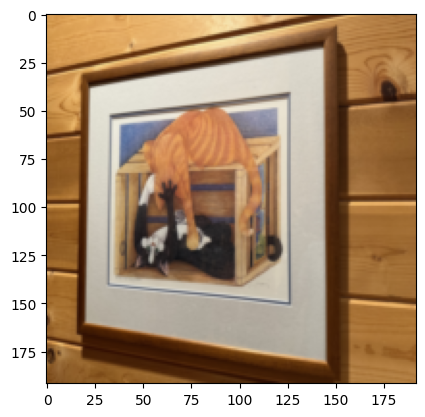

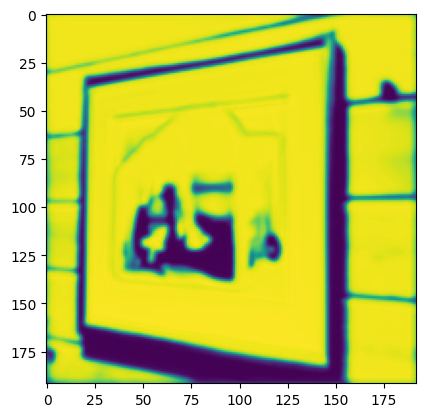

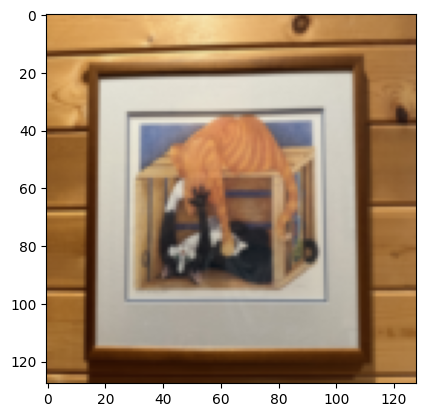

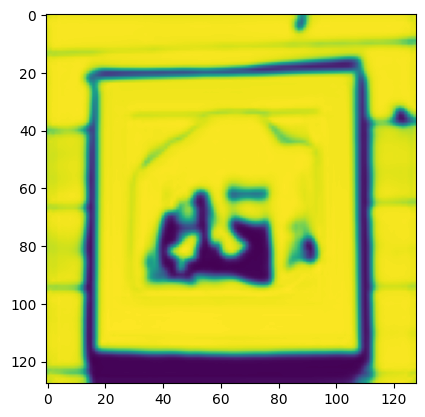

In [15]:
plt.imshow(input_img[0,:,:,:])
plt.show()
plt.imshow(input_feature_map_one[0,:,:,0])
plt.show()
plt.imshow(template_img[0,:,:,:])
plt.show()
plt.imshow(template_feature_map_one[0,:,:,0])
plt.show()

In [16]:
warped_input_img = LK_layer_regression.projective_inverse_warp(
    tf.dtypes.cast(input_img, tf.float32), # The image to be warped
    predicted_matrix                             # The homography matrix to apply
)

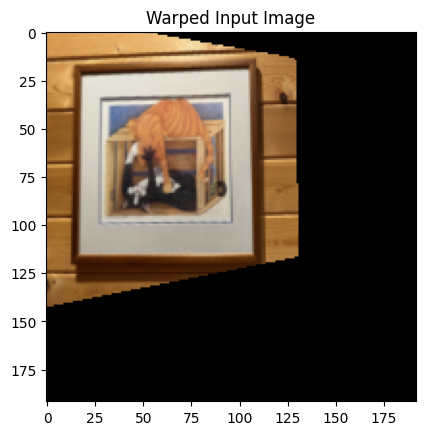

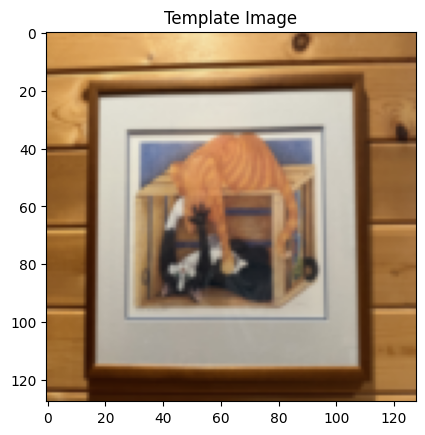

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Enable NumPy behavior for TensorFlow tensors
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

# Display the warped template image (TensorFlow EagerTensor, likely in [0,1] float range)
plt.imshow((warped_input_img[0, :, :, :] * 255).astype(np.uint8))
plt.title("Warped Input Image")
plt.show()

# Display the original input image (TensorFlow EagerTensor, likely in [0,1] float range)
plt.imshow((template_img[0, :, :, :] * 255).astype(np.uint8))
plt.title("Template Image")
plt.show()

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf


# 1. Get the dimensions of the template_img
template_height, template_width, _ = template_img[0].shape

# 2. Re-initialize LK_layer_regression with the template's dimensions
LK_layer_for_final_warp = Lucas_Kanade_layer(
    batch_size=1, # Keep batch size as 1
    height_template=template_height,
    width_template=template_width,
    num_channels=3
)

warped_input_img = LK_layer_for_final_warp.projective_inverse_warp(
    tf.dtypes.cast(input_img, tf.float32),
    predicted_matrix
)

# Display the warped input image
plt.imshow((input_img[0, :, :, :].numpy() * 255).astype(np.uint8))
plt.title("Input Image (Same Dimensions as Template)")
plt.show()

plt.imshow((warped_input_img[0, :, :, :].numpy() * 255).astype(np.uint8))
plt.title("Warped Input Image (Same Dimensions as Template)")
plt.show()

# Display the original template image
plt.imshow((template_img[0, :, :, :] * 255).astype(np.uint8))
plt.title("Template Image")
plt.show()

NameError: name 'template_img' is not defined